In [18]:
import sys
import time
import argparse
import matplotlib.pyplot as plt
import os

#sys.path.append('../sig_gen/') # adding signal generator path so that we can call a script from sig_gen folder
sys.path.insert(0, os.path.abspath(os.path.join('..') + '/sig_gen/'))
from sg_smb100a_generate_power_levels_1 import SG_SOCK # Import the Signal Generator Socket class from sig_gen folder

#from sg_smb100a_generate_power_levels_1 import power
#%%
#-----------------------import libraries for Spectrum analyzer----------------#
sys.path.insert(0, os.path.abspath(os.path.join('..') + '/spec_ana/'))
from sa_fsh8_read_channel_power_at_different_levels_1 import SA_SOCK        # Import the Spectrum Analyser Socket Function
#from sa_fsh8_read_channel_power_at_different_levels_1 import channel_power

# -----------------Connection Settings----------------------
SG_PORT = 5025                      # default SMB R&S port 
SG_HOST = '10.8.88.166'             # smb100a signal generator IP
SG_ADDRESS = (SG_HOST, SG_PORT)
SA_HOST = '10.8.88.138'             # fsh8 spectrum analyzer IP temporary
SA_PORT = 5555                      # fsh8 spectrum analyzer port 18? 23?
SA_ADDRESS = (SA_HOST, SA_PORT)
#-----------------------------------------------------------
# ----------------Initialization of Variables---------------    
DEFAULT_TIMEOUT = 1        # Default socket timeout
RF_OFF = 0
RF_ON = 1

# -----------------SA AND SG INITIALIZATION-----------------

#-----------------SA_FSH8 initialization Variables----------
NUMPOINTS = 631   # Number of measurement points (Max=625)
RBW = 1e5         # Resolution BW of spectrum analyser
VBW = 3e6       # Video BW of spectrum analyser

In [19]:
#-------------------SG_SMB100A Setup-------------------------#
def setupSG():  
    print('/------ Connect Signal Generator ---------/')
    sigGen = SG_SOCK()                                 # Call main class
    sigGen.connectSigGen(SG_ADDRESS) 
    print('/------End of Connect signal generator---------/')
    return sigGen

#------------------------SA_FSH8 Setup-------------------------#
def setupSA():
    print('/------Setup spectrum analyser---------/')
    specAnal = SA_SOCK()
    specAnal.connectSpecAna((SA_ADDRESS))
    specAnal.setSpecAnaBandwidth('off', RBW, 'off', VBW) # Set the SA Resolution bandwidth mode to Manual, 100 KHz. Set the Video BW to Manual, 100 KHz 
    specAnal.setSpecAnaAmplitude(-10, 10) 
    print('/------End of Setup Spectrum Analyzer---------/')
    return specAnal
        
#------------------------------ PLOT ---------------------------#
def plotTrace(x_axis, y_axis, x_label, y_label, title, label): 

    plt.figure(figsize=(10,10))
    plt.plot(x_axis, y_axis, 'r', label = label)
    plt.plot(x_axis, y_axis, 'rx')
    plt.legend()
    plt.xlabel(x_label, fontsize = 16)
    plt.ylabel(y_label, fontsize = 16)
    plt.title(title, fontsize = 20)
    plt.grid()
    plt.show()



In [20]:
freq_start = 1e9
freq_stop = 2e9

SigGen = setupSG()
SpecAna = setupSA()
time.sleep(1) 
SpecAna.setSpecAnaSweep(freq_start, freq_stop, NUMPOINTS)

# Setup Signal Generator
cent_freq = SpecAna.requestSpecAnaData('FREQ:CENT?')
SigGen.setSigGenFreq(cent_freq.decode())
SigGen.setSigGenRF(RF_ON)

/------ Connect Signal Generator ---------/
Connected to: b'Rohde&Schwarz,SMB100A,1406.6000k02/102027,3.1.19.15-3.20.390.24 '
/------End of Connect signal generator---------/
/------Setup spectrum analyser---------/
Connected to: b'Rohde&Schwarz,FSH8,106260/028,V3.30'
SA RBW set to AUTO 0, RBW = 100.0 kHz
SA VBW set to AUTO 0, VBW = 3000.0 kHz
SA amplitude reference level set to REF -10.0 dBm
SA input attenuator set to 10.0 dB
/------End of Setup Spectrum Analyzer---------/
SA Start Freq: 1000.0 MHz, Stop Freq: 2000.0 MHz, Points: 631
Signal Generator Frequency = 1500.0 MHz
RF Output On


In [25]:
# Set and read channel power values
start_power = -70
stop_power = -40
step_power = 10
chan_bw = 3e6

input_power = []
sa_power_level = []

SpecAna.configSpecAnaPow(chan_bw, 'CLR', 'DBM')
current_power = start_power
while current_power <= stop_power:
    SigGen.setSigGenPower(current_power) 
    sa_band_power = SpecAna.getSpecAnaPower() # for setting window , we can change a window by parsing a differnty cbw
    print(f'Spectrum Analyser Band Power: {sa_band_power} dBm')
    input_power.append(current_power)  
    sa_power_level.append(sa_band_power)   #sa_power_level
    current_power += step_power


Sig gen power = -70.0 dBm
Spectrum Analyser Band Power: -70.405 dBm
Sig gen power = -60.0 dBm
Spectrum Analyser Band Power: -63.165 dBm
Sig gen power = -50.0 dBm
Spectrum Analyser Band Power: -53.446 dBm
Sig gen power = -40.0 dBm
Spectrum Analyser Band Power: -43.446 dBm


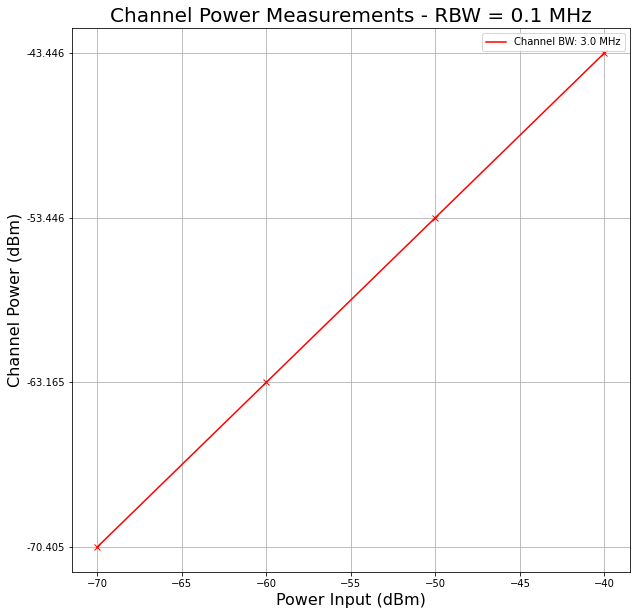

In [27]:
# Plot the results
plotTrace(input_power, sa_power_level, 'Power Input (dBm)', 'Channel Power (dBm)', f'Channel Power Measurements - RBW = {RBW/1e6} MHz', f'Channel BW: {chan_bw/1e6} MHz')

In [21]:
#Trying different channel sizes
start_power = -70
stop_power = -40
step_power = 5
chan_bw = [1e6, 10e6, 30e6, 100e6, 300e6]

output_data = []
for bw in chan_bw:
    input_power = []  
    sa_power_level = []
    SpecAna.configSpecAnaPow(bw, 'CLR', 'DBM')
    print(f'Channel Bandwidth: {bw/1e6} MHz')
    current_power = start_power
    while current_power <= stop_power:
        SigGen.setSigGenPower(current_power)
        sa_band_power = SpecAna.getSpecAnaPower() # for setting window , we can change a window by parsing a differnty cbw
        print(f'Spectrum Analyser Band Power: {sa_band_power} dBm')
        input_power.append(current_power)
        sa_power_level.append(float(sa_band_power))   #sa_power_level
        current_power += step_power
    output_data.append([bw, sa_power_level])
    


Bandwidth: 1.0 MHz
Sig gen power = -70.0 dBm
Spectrum Analyser Band Power: -72.288 dBm
Sig gen power = -65.0 dBm
Spectrum Analyser Band Power: -68.086 dBm
Sig gen power = -60.0 dBm
Spectrum Analyser Band Power: -63.194 dBm
Sig gen power = -55.0 dBm
Spectrum Analyser Band Power: -58.279 dBm
Sig gen power = -50.0 dBm
Spectrum Analyser Band Power: -53.301 dBm
Sig gen power = -45.0 dBm
Spectrum Analyser Band Power: -48.322 dBm
Sig gen power = -40.0 dBm
Spectrum Analyser Band Power: -43.308 dBm
Bandwidth: 10.0 MHz
Sig gen power = -70.0 dBm
Spectrum Analyser Band Power: -66.756 dBm
Sig gen power = -65.0 dBm
Spectrum Analyser Band Power: -65.111 dBm
Sig gen power = -60.0 dBm
Spectrum Analyser Band Power: -62.287 dBm
Sig gen power = -55.0 dBm
Spectrum Analyser Band Power: -58.052 dBm
Sig gen power = -50.0 dBm
Spectrum Analyser Band Power: -53.407 dBm
Sig gen power = -45.0 dBm
Spectrum Analyser Band Power: -48.497 dBm
Sig gen power = -40.0 dBm
Spectrum Analyser Band Power: -43.543 dBm
Bandwidth

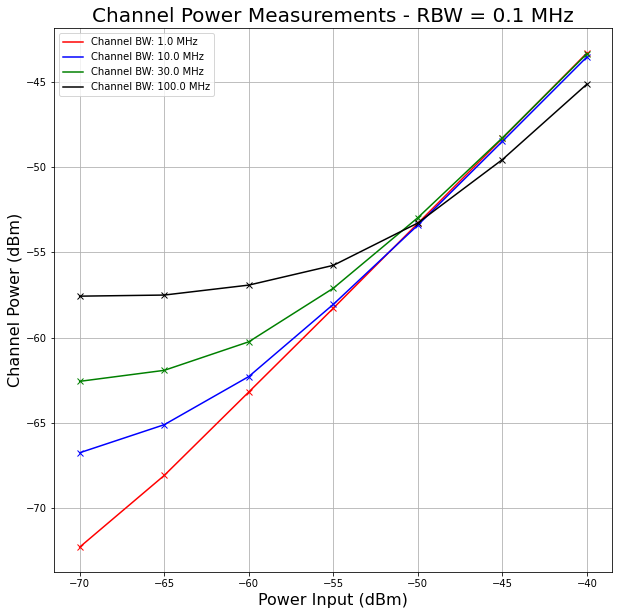

In [23]:
plt.figure(figsize=(10,10))

val = 0
plt.plot(input_power, output_data[val][1], 'r', label = f'Channel BW: {output_data[val][0]/1e6} MHz')
plt.plot(input_power, output_data[val][1], 'rx')

val = 1
plt.plot(input_power, output_data[val][1], 'b', label = f'Channel BW: {output_data[val][0]/1e6} MHz')
plt.plot(input_power, output_data[val][1], 'bx')

val = 2
plt.plot(input_power, output_data[val][1], 'g', label = f'Channel BW: {output_data[val][0]/1e6} MHz')
plt.plot(input_power, output_data[val][1], 'gx')

val = 3
plt.plot(input_power, output_data[val][1], 'k', label = f'Channel BW: {output_data[val][0]/1e6} MHz')
plt.plot(input_power, output_data[val][1], 'kx')

#val = 4
#plt.plot(input_power, output_data[val][1], 'm', label = f'Channel BW: {output_data[val][0]/1e6} MHz')
#plt.plot(input_power, output_data[val][1], 'mx')

#val = 5
#plt.plot(input_power, output_data[val][1], 'c', label = f'Channel BW: {output_data[val][0]/1e6} MHz')
#plt.plot(input_power, output_data[val][1], 'cx')

plt.legend()
plt.xlabel('Power Input (dBm)', fontsize = 16)
plt.ylabel('Channel Power (dBm)', fontsize = 16)
plt.title(f'Channel Power Measurements - RBW = {RBW/1e6} MHz', fontsize = 20)
plt.grid()
plt.show()
